In [1]:
import pandas as pd
import numpy as np
#from polygon import RESTClient
import datetime
import json
import requests
import os
import math
import matplotlib.pyplot as plt
from dotenv import load_dotenv
load_dotenv()

%matplotlib inline

In [2]:
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

# Time series Models
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression


#Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
def financials(ticker):
    financials = "https://api.polygon.io/v2/reference/financials/"+ticker+"?limit=80&type=Q&apiKey=XrTJjjYQpsWD5i9Gn1vBE1LEu1J1R5gJ"
    response_data = requests.get(financials).json()
    df = pd.DataFrame(response_data['results'])
    #df = df[["calendarDate", "assetsCurrent", 'cashAndEquivalentsUSD', "sharePriceAdjustedClose", 'investmentsCurrent', 'assetsCurrent', 'debtToEquityRatio', 'debtUSD', 'dividendYield', 'earningsBeforeInterestTaxesDepreciationAmortizationUSD', 'EBITDAMargin', 'shareholdersEquityUSD', 'enterpriseValue']]
    return df

In [5]:
tickers = ['HD']#, 'IDXX', 'CAT', 'CARR', 'AMP']
test_df = pd.DataFrame()
for ticker in tickers:
    print(ticker)
    data = financials(ticker)
    #data = data.set_index('calendarDate')
    data = data.drop(['ticker', 'period', 'reportPeriod', 'updated', 'dateKey' ], axis=1)
    data = data.add_prefix(f'{ticker}_')
    test_df = pd.concat([test_df, data], axis=1, join='outer')
    #test_df = test_df.rename(columns={f'{ticker}_calendarDate': 'calendarDate'})
    #test_df=test_df.set_index('calendarDate')
    #test_df.index = pd.to_datetime(test_df.index,dayfirst=False, yearfirst=True, format= "%d/%m/%Y", infer_datetime_format=True )



HD


In [6]:
for i in tickers:
    test_df = test_df.rename(columns={f'{i}_calendarDate': 'calendarDate'})
    test_df=test_df.set_index('calendarDate')
    test_df.index = pd.to_datetime(test_df.index,dayfirst=False, yearfirst=True, format= "%d/%m/%Y", infer_datetime_format=True )

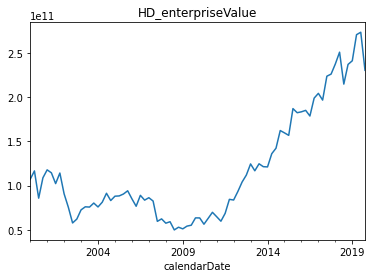

In [7]:
for i in tickers:
    test_df[f'{i}_enterpriseValue'].plot(title = f'{i}_enterpriseValue')

In [8]:
return_period = 2
for i in tickers:

    X=test_df.drop(columns = [f'{i}_enterpriseValue']).diff(return_period).dropna()
    Y=test_df.loc[:,f'{i}_enterpriseValue'].diff(return_period).shift(-return_period).dropna()
    df = pd.concat([Y,X], axis=1, join='outer').dropna().iloc[::return_period, :]
    #df = df.sort_index(ascending=False)

In [9]:
col_list = df.columns[:]


In [10]:
data = df.values[:, :]
trans = StandardScaler()
data = trans.fit_transform(data)
dataset = pd.DataFrame(data)
dataset = dataset.dropna()

In [11]:
dataset.columns = col_list    

<AxesSubplot:title={'center':'Correlation Matrix'}>

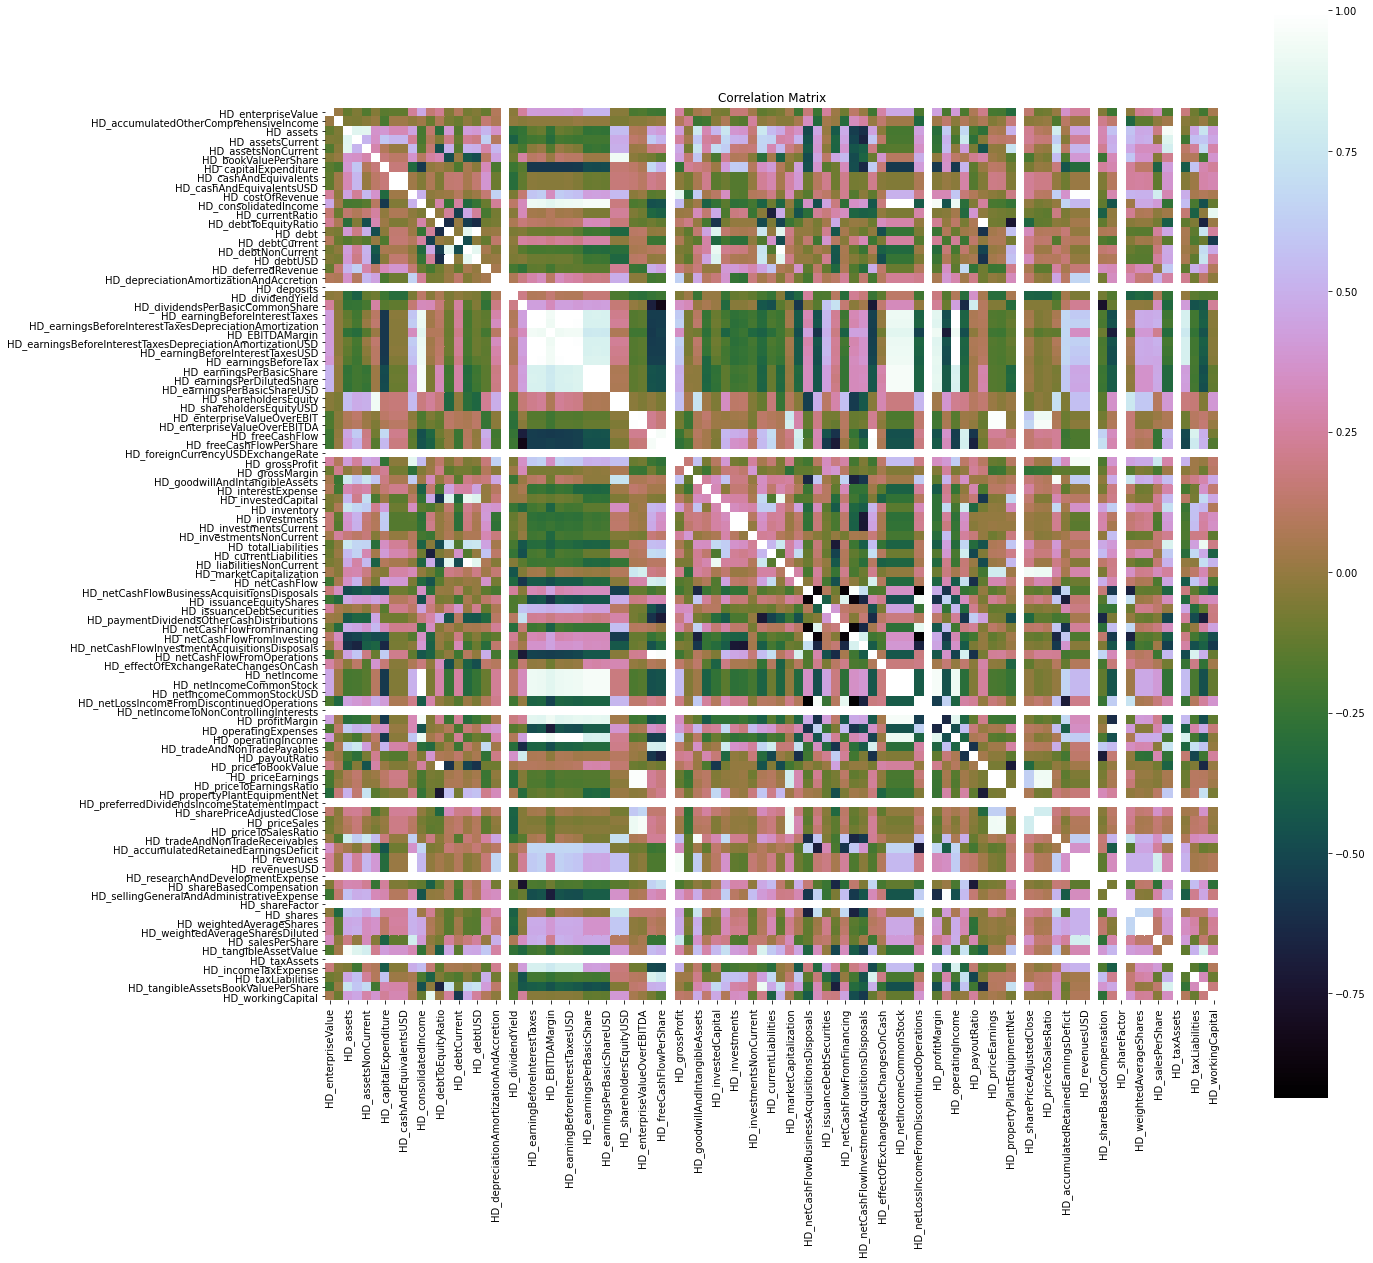

In [12]:
correlation = dataset.corr()
pyplot.figure(figsize=(20,20))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=False,cmap='cubehelix')


In [13]:
# res = sm.tsa.seasonal_decompose(Y,freq=1) 
# fig = res.plot()
# fig.set_figheight(14)
# fig.set_figwidth(20)
# pyplot.show()

In [14]:
validation_size = 0.2
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)] 
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

In [15]:
num_folds = 10
scoring = 'neg_mean_squared_error'


In [16]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(10,'Score').set_index('Specs')  #print 10 best features

,Score
Specs,
HD_marketCapitalization,4074.201456
HD_sharePriceAdjustedClose,833.027330
HD_priceSales,326.675817
HD_priceToSalesRatio,305.208299
HD_enterpriseValueOverEBITDA,143.135044
HD_priceToEarningsRatio,108.988035
HD_priceEarnings,107.223114
HD_enterpriseValueOverEBIT,105.983388
HD_dividendYield,23.462221


In [17]:
X=X[['HD_marketCapitalization','HD_sharePriceAdjustedClose','HD_priceSales','HD_priceToSalesRatio','HD_enterpriseValueOverEBITDA','HD_priceToEarningsRatio','HD_priceEarnings','HD_enterpriseValueOverEBIT','HD_dividendYield','HD_issuanceEquityShares']]



In [18]:
validation_size = 0.5

train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

In [19]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

In [20]:
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

In [21]:
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold(n_splits=num_folds) #random_state=seed)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 5578354959125682176.000000 (7776182826134856704.000000) 1222768255154613248.000000 16951162833600647168.000000
LASSO: 5379747165991610368.000000 (7684923952478112768.000000) 1232449790729070592.000000 14179271412838342656.000000
EN: 3367684247097448960.000000 (3660666738620753408.000000) 2310908856785069056.000000 11134585463395811328.000000
KNN: 32675741860217028608.000000 (70745930813433102336.000000) 20151170578749386752.000000 27872696592622010368.000000
CART: 23808349490861670400.000000 (28982059413628203008.000000) 0.000000 104888172813929250816.000000
SVR: 278963604194113814528.000000 (261898968139670257664.000000) 276672726630247727104.000000 447820312166974357504.000000
ABR: 28611041396834500608.000000 (52765282039303159808.000000) 1186265243704450048.000000 40959081930335002624.000000
GBR: 20189933394588721152.000000 (43396383472636297216.000000) 977596205678970.625000 24567138429370900480.000000
RFR: 22847471390795505664.000000 (53350479746235793408.000000) 2051514923204

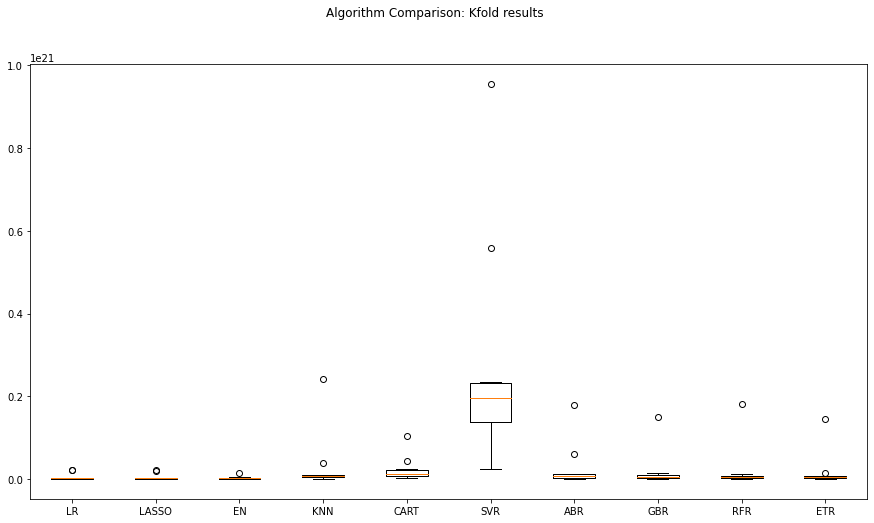

In [22]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

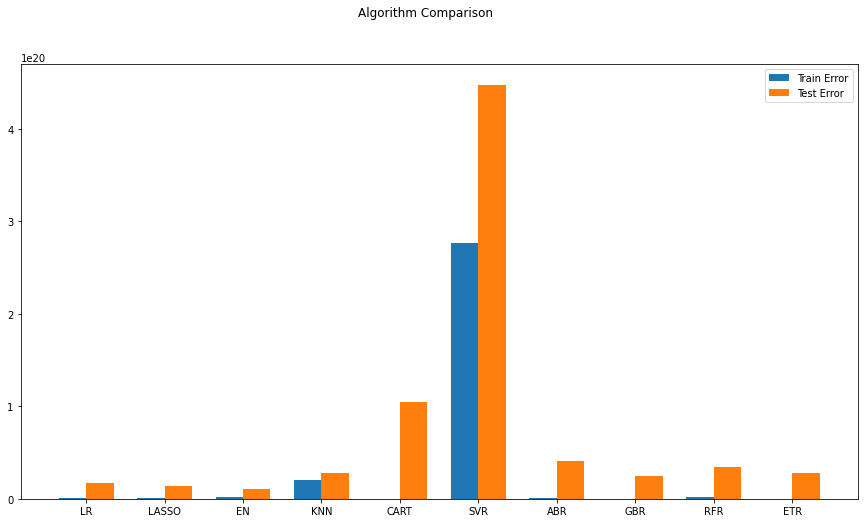

In [23]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

In [24]:
enterpriseValue = LinearRegression()
enterpriseValue.fit(X_train, Y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [25]:
y_pred = enterpriseValue.predict(X_test)

Text(0.5, 1.0, 'enterpriseValue')

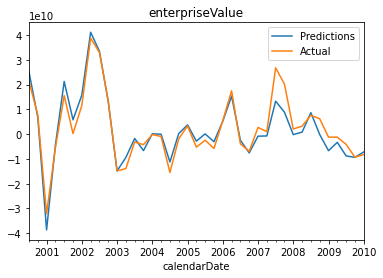

In [26]:
results = pd.DataFrame({"Predictions": y_pred, "Actual": Y_test})
results.plot()
plt.title('enterpriseValue')

In [27]:
model_elast = ElasticNet(alpha=1.0, l1_ratio=0.5)
model_elast.fit(X_train, Y_train)

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [28]:
elast_pred = model_elast.predict(X_test)
elast_results = pd.DataFrame({"Predictions": elast_pred, "Actual": Y_test})

Text(0.5, 1.0, 'Elastic Net Performance')

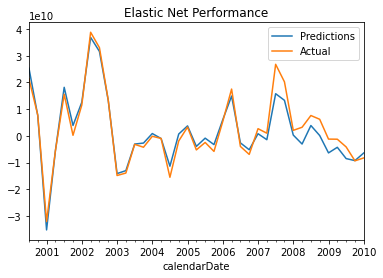

In [29]:
elast_results.plot()
plt.title('Elastic Net Performance')

In [30]:
reg = Lasso(alpha=0.5)
reg.fit(X_train, Y_train)

Lasso(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [31]:
reg_pred = reg.predict(X_test)
reg_results = pd.DataFrame({"Predictions": reg_pred, "Actual": Y_test})

Text(0.5, 1.0, 'Lasso Performance')

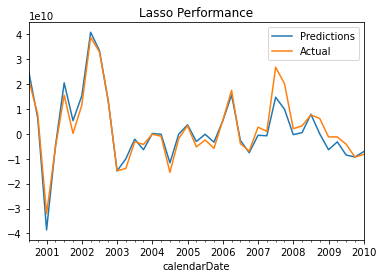

In [32]:
reg_results.plot()
plt.title('Lasso Performance')